In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import functions
from GP import GP
from GP_grad import GP_grad
import time
import imageio

In [2]:
Noise = True # Specify if noisy or not
Noise_level = 0.1 # if noisy, what is the noise sd
'''If use the scaled X and Y, rememeber to scale the noise as well'''

'If use the scaled X and Y, rememeber to scale the noise as well'

In [3]:
# objective = functions.sincos(Noise, Noise_level)
objective = functions.sin_add(Noise, Noise_level)

bounds = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(bounds) 

f = objective.func
print(f( np.array([2, 1]) ))
# np.sin(np.array([2, 1]))

dim = objective.input_dim
print('dim: ', dim)

[[-1. 15.]]
[[1.28570266]
 [0.98148671]]
dim:  1


In [4]:
# max budget for finding good point
Budget = 100
# set seed
seed = 0
# Acq_names=['PI','PG','EI','EG','gp_ucb','random','TS','SATS','G_ES','MES']
acquation_function = 'random'

In [5]:
def draw(n_random_draws=3):
    """ samples some points"""
    # np.random.seed(seed) 
    # should draw randomly
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_random_draws, dim))
    return X, f(X)

gp = GP_grad(bounds, Noise, Noise_level)

def get_kernel(sample_size=200):
    np.random.seed(seed)
    X = np.asarray(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(sample_size, dim)))
    gp.set_data(X, f(X))
    # gp.optimize()
    gp.fit()
    return gp.get_hyper()

In [6]:
get_kernel(200)
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1, dim)
mu, covar = gp.posterior(Xtest)
s = np.sqrt(np.diag(covar))
mu = np.squeeze(mu)


Kt = gp.cov_RBF(Xtest, Xtest, gp.get_hyper())
K_11 = gp.K11(Xtest)
K_01 = gp.K01(Xtest)

In [7]:
gp.X.shape

(200, 1)

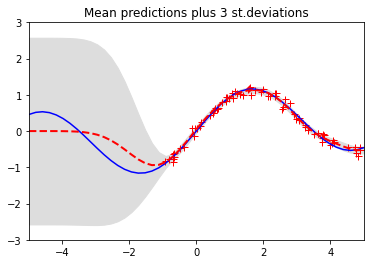

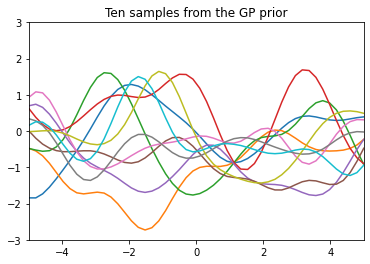

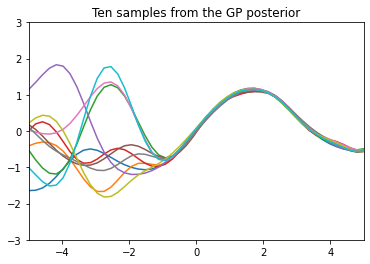

In [8]:
# plot
X = np.squeeze(gp.X)
y = np.squeeze(gp.y)

Xtest = np.squeeze(Xtest)

pl.figure(1)
pl.clf()
pl.plot(X, y, 'r+', ms=7)
pl.plot(Xtest, np.sin(Xtest) + 0.1*Xtest, 'b-')
pl.gca().fill_between(Xtest.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")

pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(Kt + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar + 1e-6*np.eye(n)) # LL^T = Sigma (posterior covariance)
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n, 10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [9]:
mu_grad, covar_grad = gp.posterior_grad(Xtest)
s_grad = np.sqrt(np.diag(covar_grad))
mu_grad = np.squeeze(mu_grad)

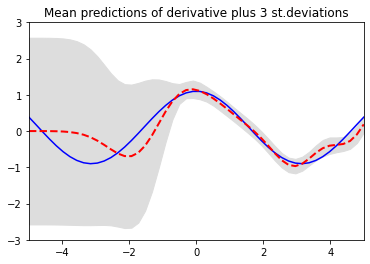

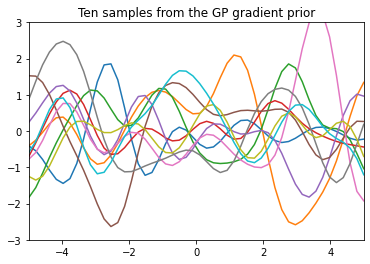

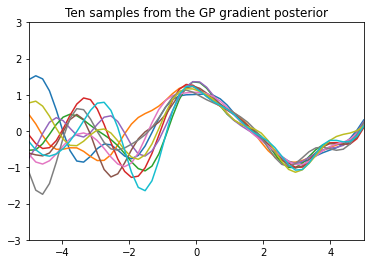

In [10]:
# plot
pl.figure(1)
pl.clf()
# pl.plot(X, y, 'r+', ms=7)
pl.plot(Xtest, np.cos(Xtest) + 0.1 * np.ones(Xtest.shape), 'b-')
pl.gca().fill_between(Xtest.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")

pl.plot(Xtest, mu_grad, 'r--', lw=2)
pl.savefig('predictive_grad.png', bbox_inches='tight')
pl.title('Mean predictions of derivative plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_11 + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n, 10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP gradient prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior_grad.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar_grad + 1e-6*np.eye(n)) # LL^T = Sigma (posterior covariance)
f_post = mu_grad.reshape(-1,1) + np.dot(L, np.random.normal(size=(n, 10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP gradient posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post_grad.png', bbox_inches='tight')

pl.show()

In [12]:
mu_grad-2.576*s_grad < np.cos(Xtest) + 0.1 * np.ones(Xtest.shape)
mu_grad+2.576*s_grad > np.cos(Xtest) + 0.1 * np.ones(Xtest.shape)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True])

## Gradient descent

In [11]:
gp = GP_grad(bounds, Noise, Noise_level)
mesh = np.linspace(-5, 15, 2000).reshape((-1, dim))
np.random.seed(seed)  

X = np.asarray(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(4, dim)))
gp.set_data(X, f(X))
gp.fit()
mu, covar = gp.posterior(mesh)


n_iter = 40
lr_init = 15
alpha = 0.5

history = []
history_lr = []
w = X[0].reshape(-1, 1)
    
def grad(gp, x): # input a fit gp, find the gradient at x
    assert gp.dim == 1
    # partial x1
    gp.set_p(0)
    m1, v1 = gp.posterior_grad(x)
    s1 = np.sqrt(np.diag(v1))

#     # partial x2
#     gp.set_p(1)
#     m2, v2 = gp.posterior_grad(x)
#     s2 = np.sqrt(np.diag(v2))
#     m2 = np.squeeze(m2)
#     return np.vstack([m1, m2])
    return m1.reshape(-1, 1)


grad(gp, w)

array([[0.59711064]])

$$F(x_n + \eta \times d_n) < F(x_n) + \alpha \times \eta \times \langle d_n, \nabla F(x_n)\rangle$$

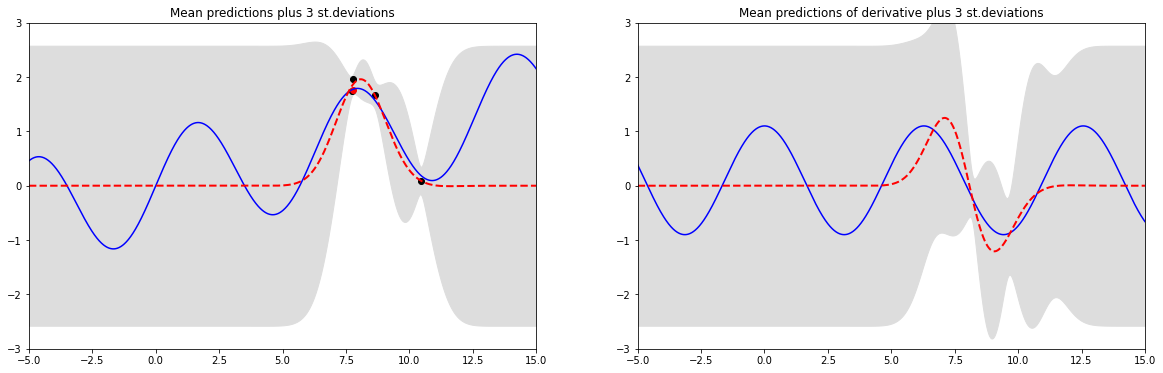

w:  [[5.54185116]]
lr:  3.75


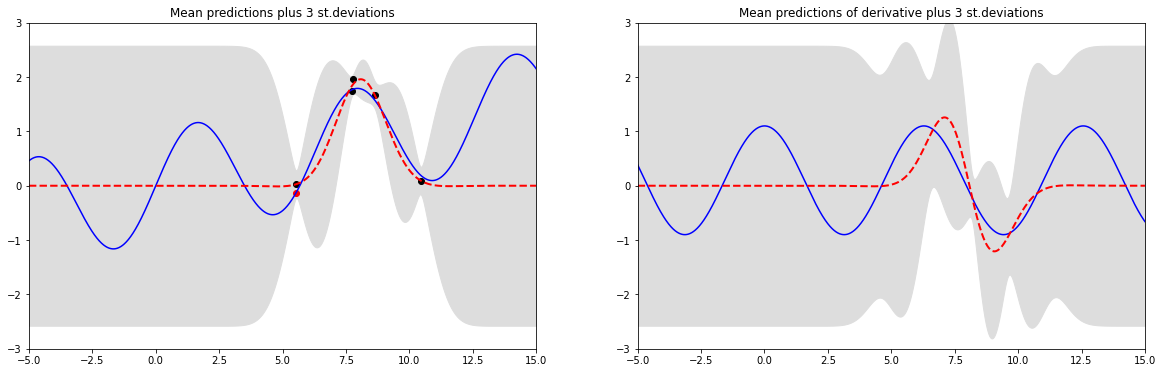

w:  [[5.53283805]]
lr:  0.05859375


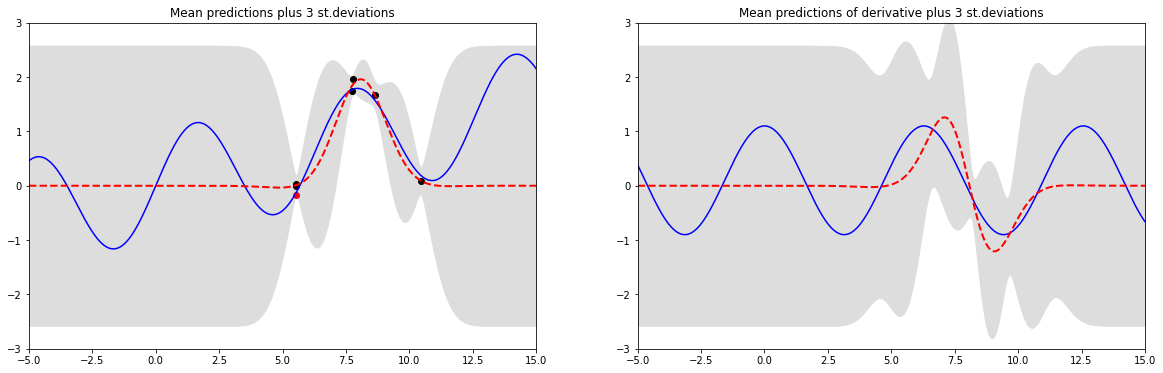

w:  [[5.51345006]]
lr:  0.1171875


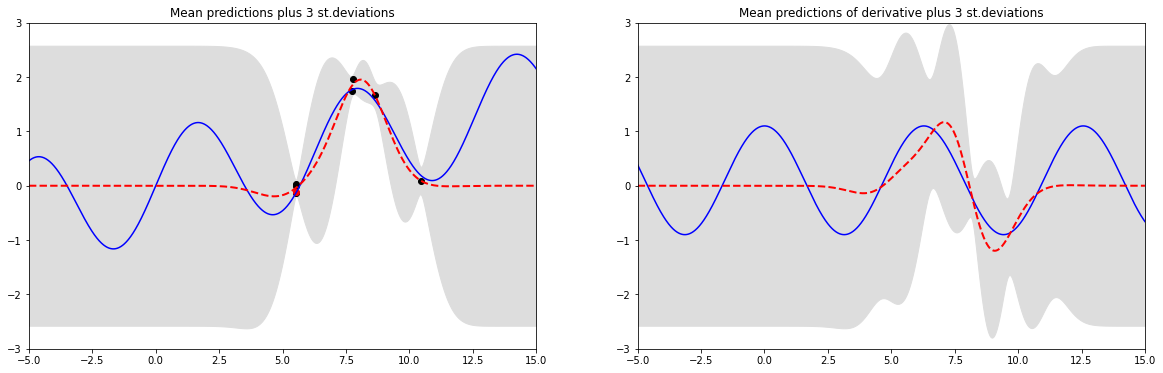

w:  [[5.50275509]]
lr:  0.029296875


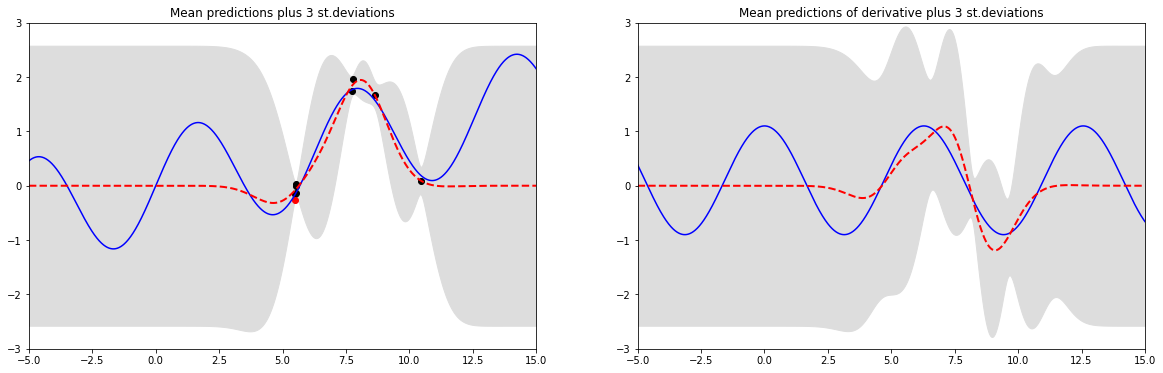

w:  [[5.48721053]]
lr:  0.029296875


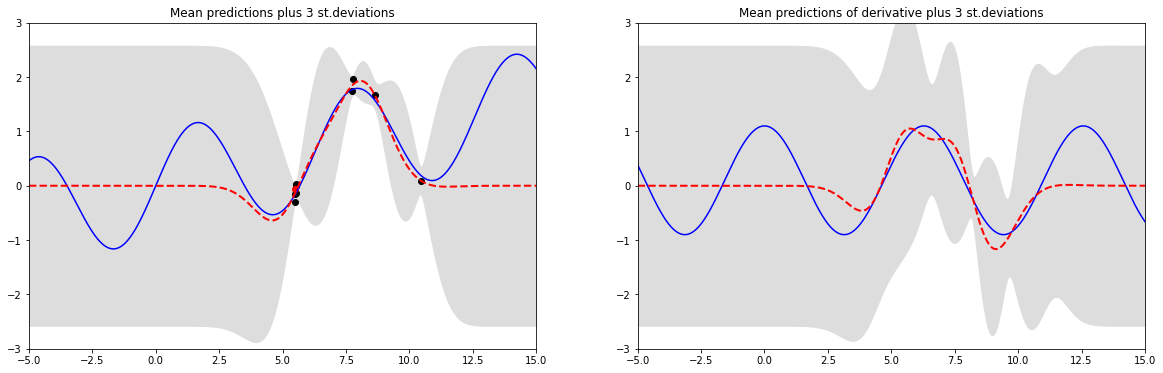

w:  [[5.45813392]]
lr:  0.029296875


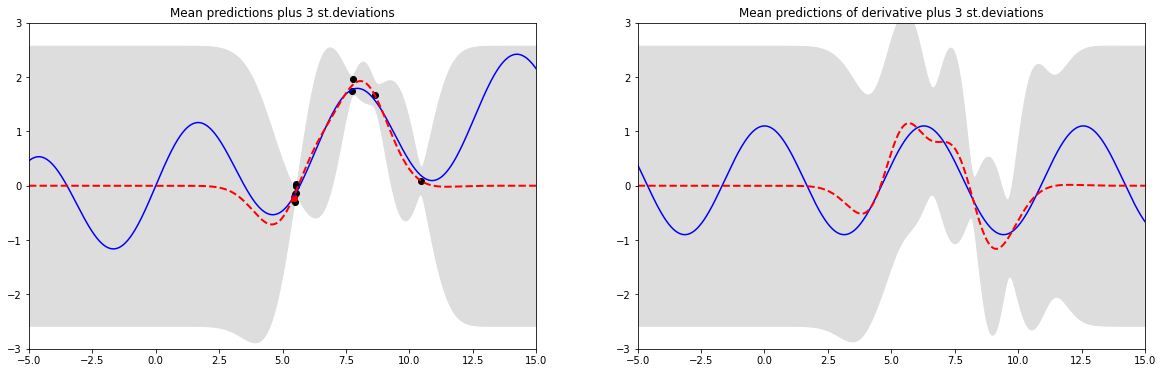

w:  [[5.39440244]]
lr:  0.05859375


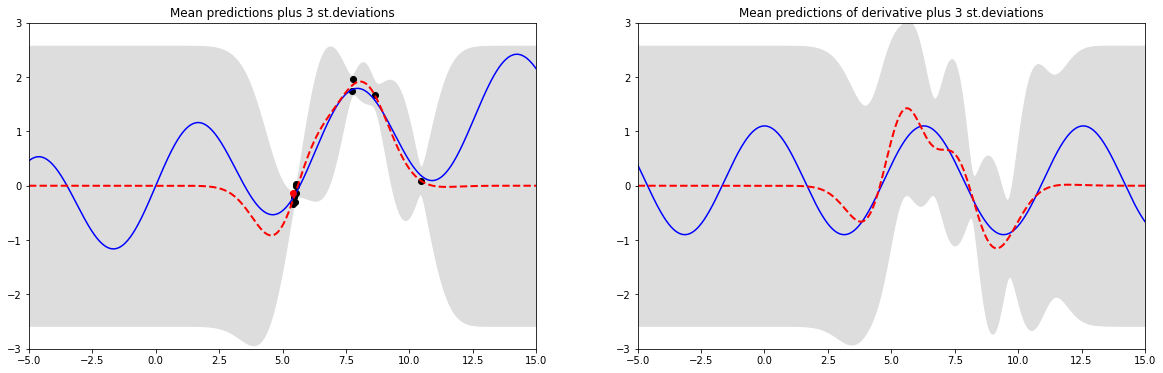

w:  [[5.31560998]]
lr:  0.05859375


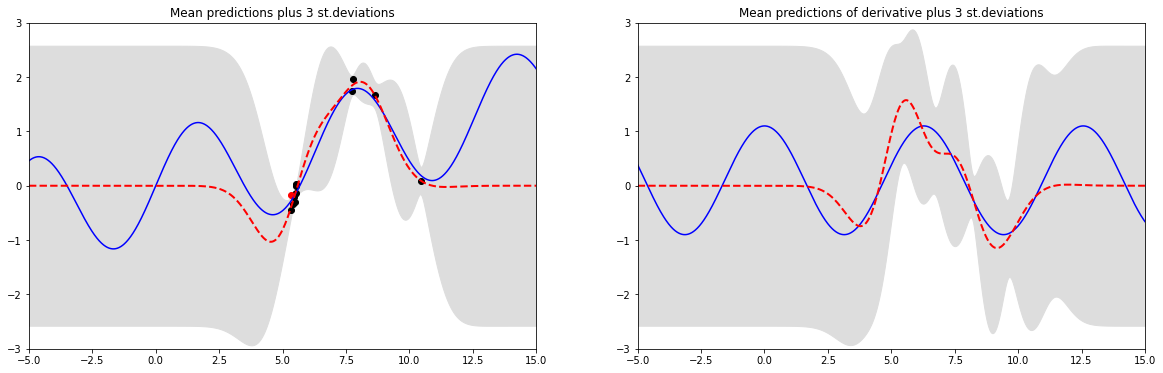

w:  [[5.1469753]]
lr:  0.1171875


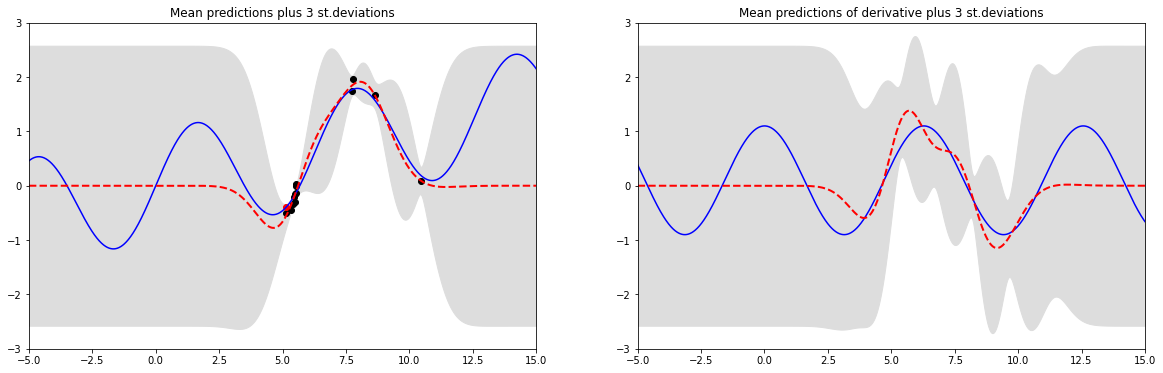

w:  [[5.14533058]]
lr:  0.0018310546875


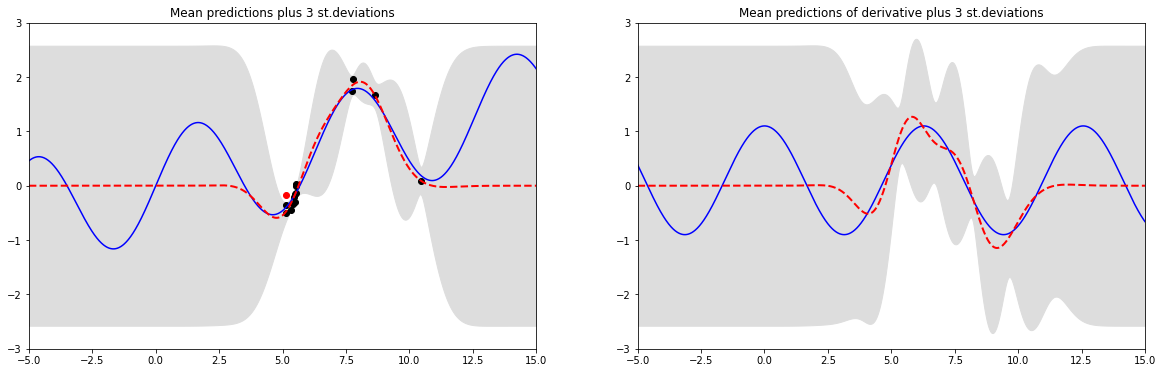

w:  [[5.10780499]]
lr:  0.05859375


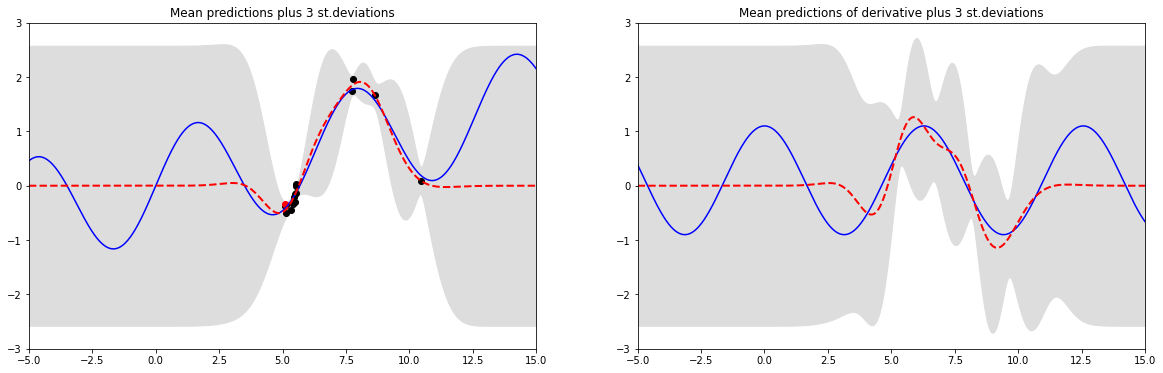

w:  [[5.09506903]]
lr:  0.029296875


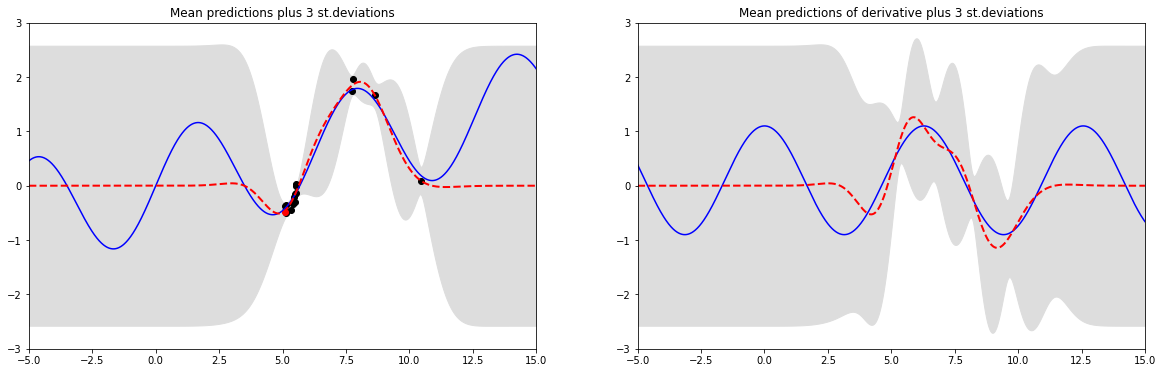

w:  [[4.69680066]]
lr:  0.9375


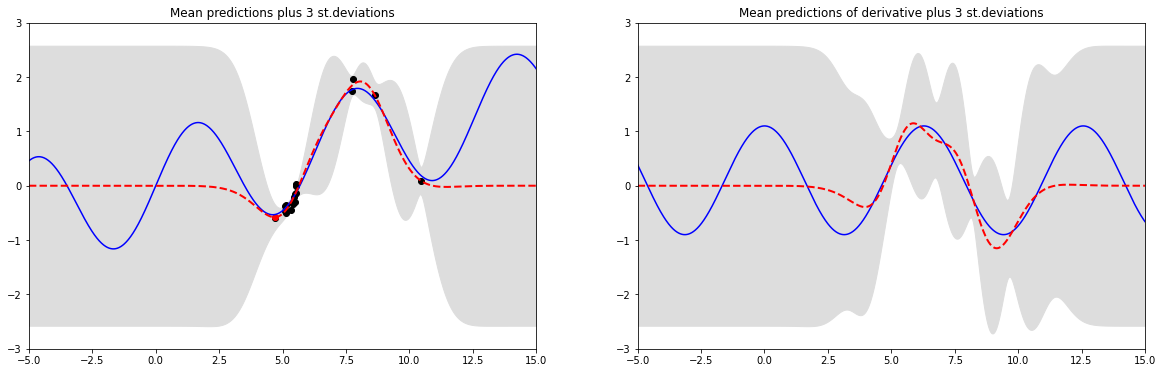

w:  [[4.56060686]]
lr:  7.5


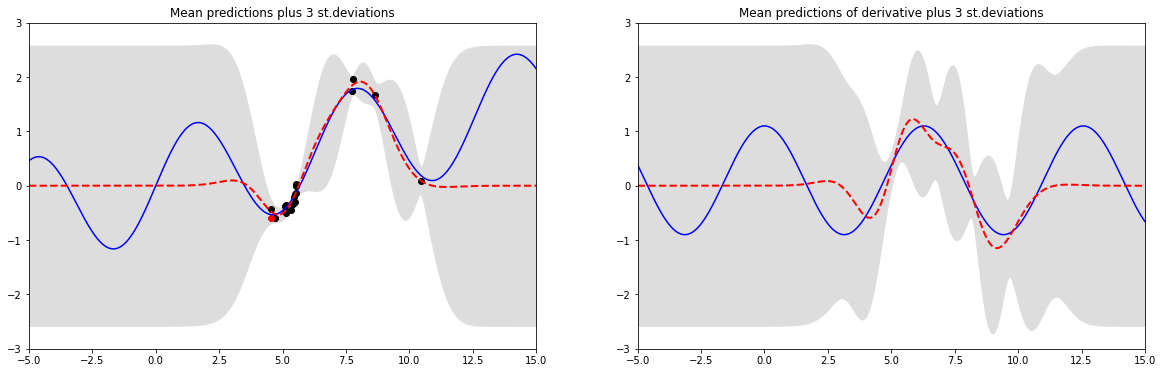

w:  [[4.90418824]]
lr:  0.9375


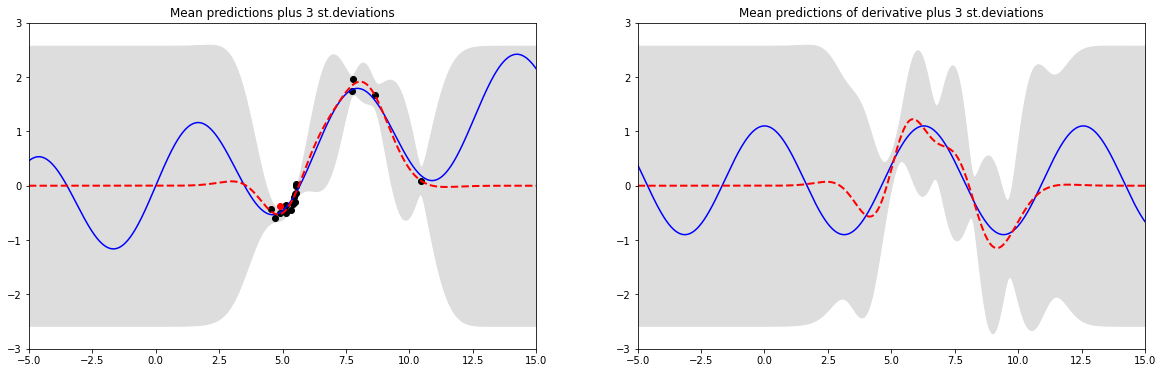

w:  [[4.40471871]]
lr:  3.75


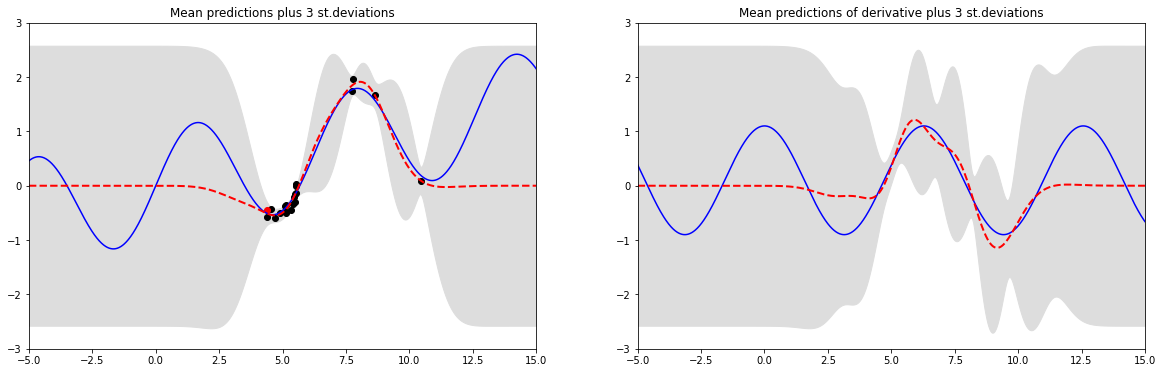

w:  [[4.44800024]]
lr:  0.234375


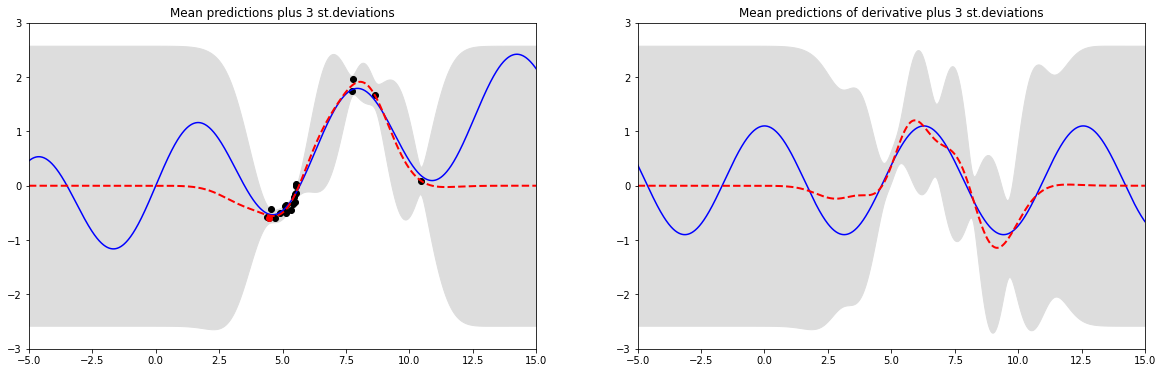

w:  [[4.84856466]]
lr:  3.75


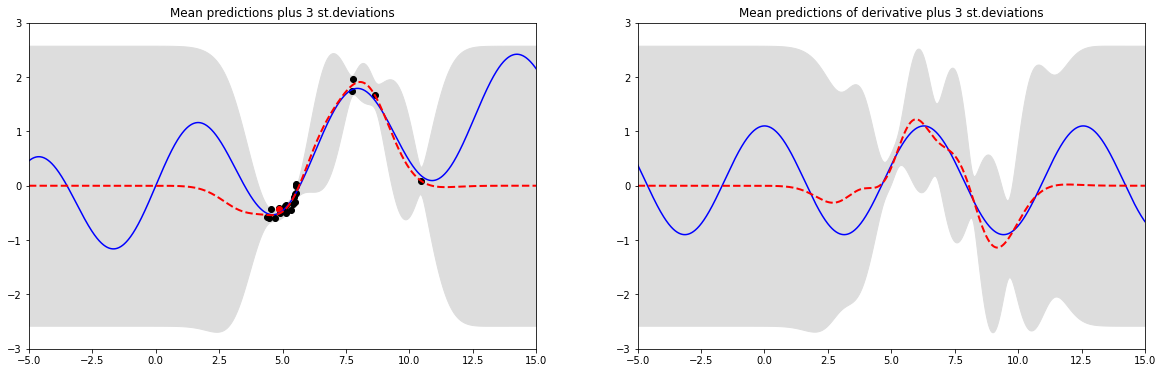

w:  [[4.80535669]]
lr:  0.234375


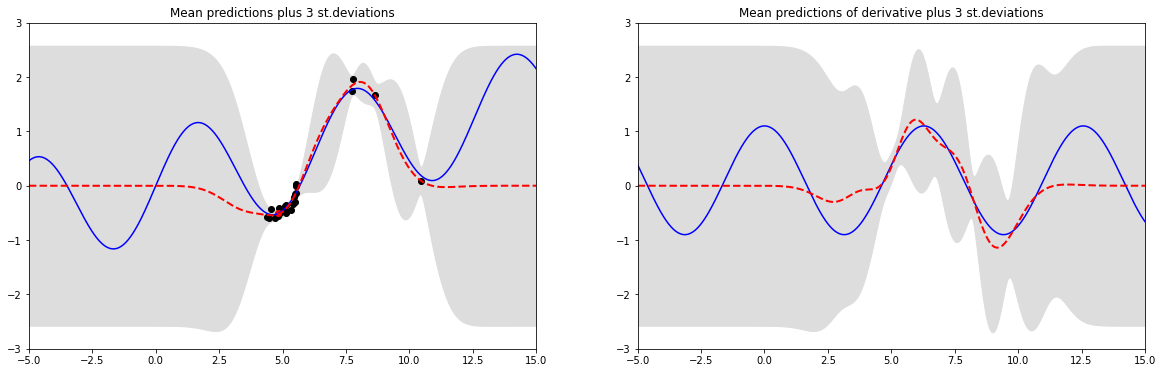

w:  [[4.66565657]]
lr:  0.9375


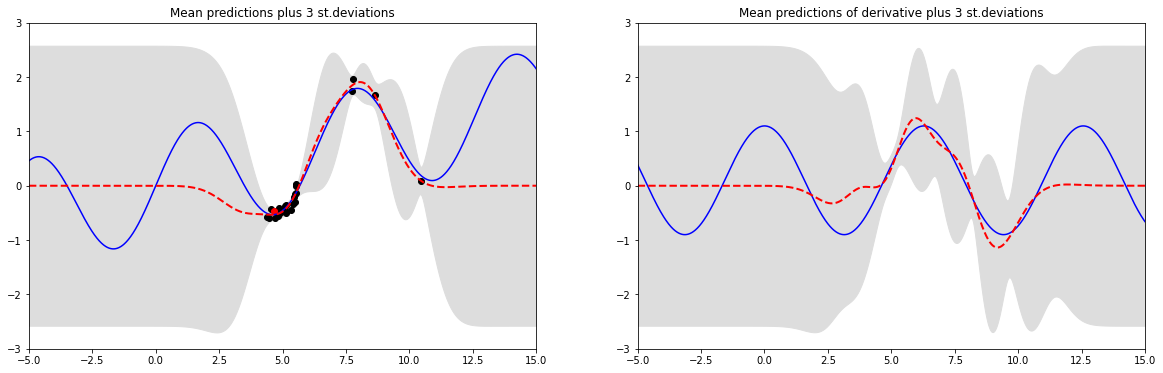

w:  [[4.57993045]]
lr:  1.875


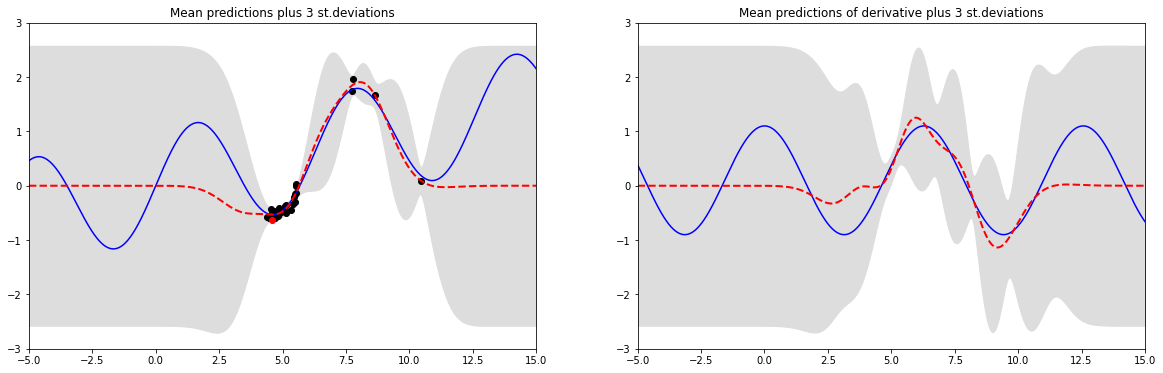

w:  [[4.55055583]]
lr:  7.5


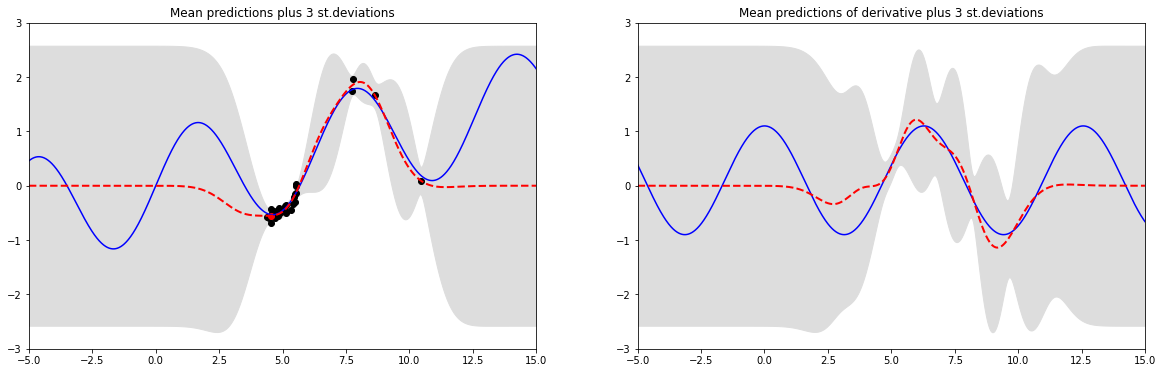

w:  [[4.4087466]]
lr:  3.75


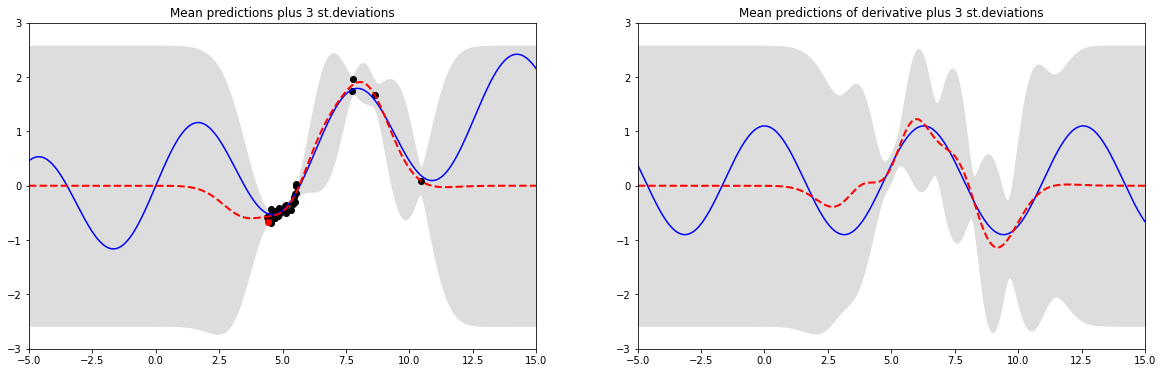

w:  [[4.35031187]]
lr:  0.9375


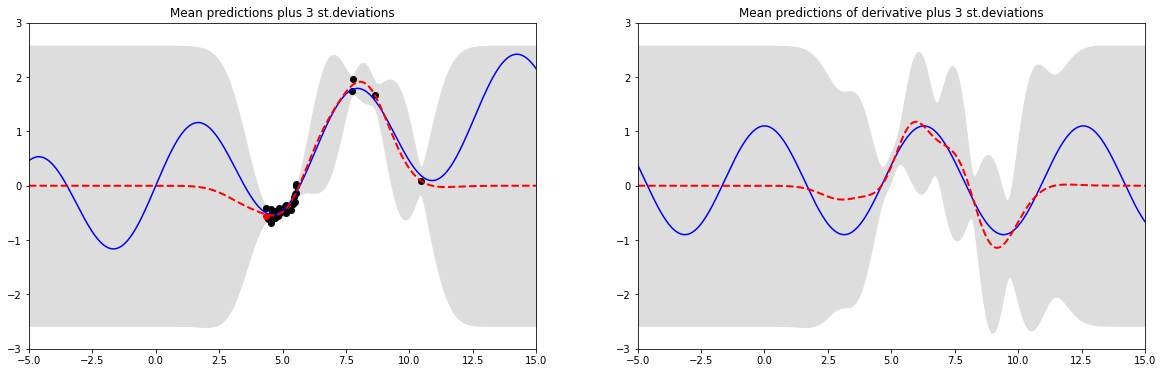

w:  [[4.3792001]]
lr:  0.234375


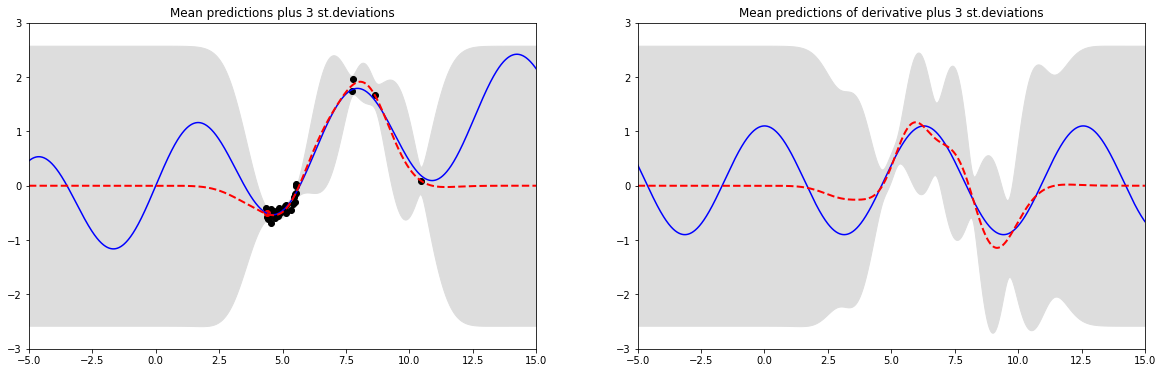

w:  [[4.45301746]]
lr:  0.46875


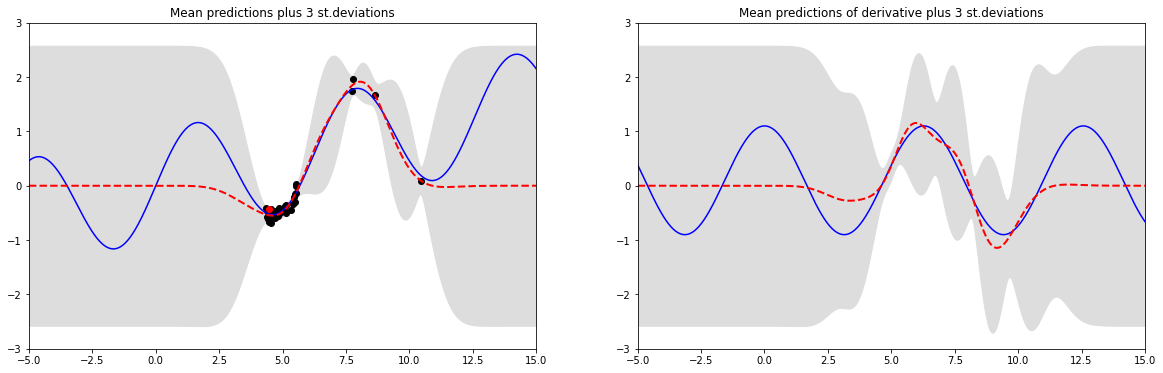

w:  [[4.53887546]]
lr:  0.9375


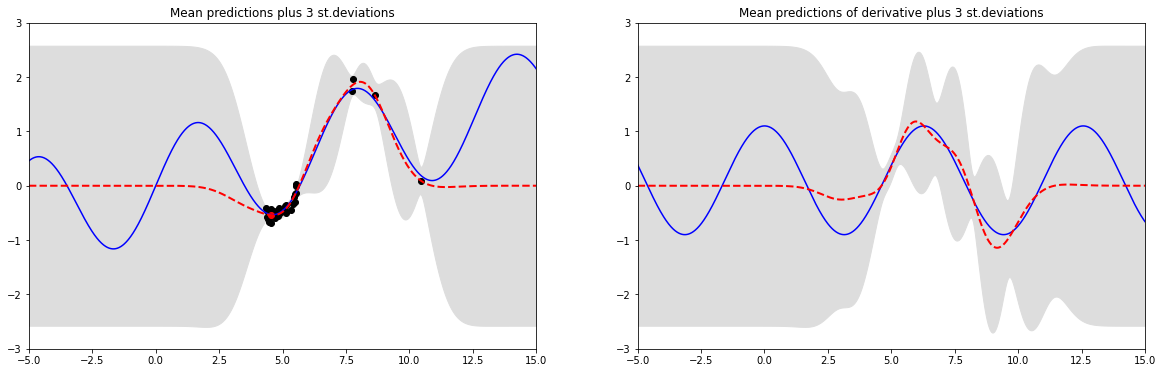

w:  [[4.70082871]]
lr:  3.75


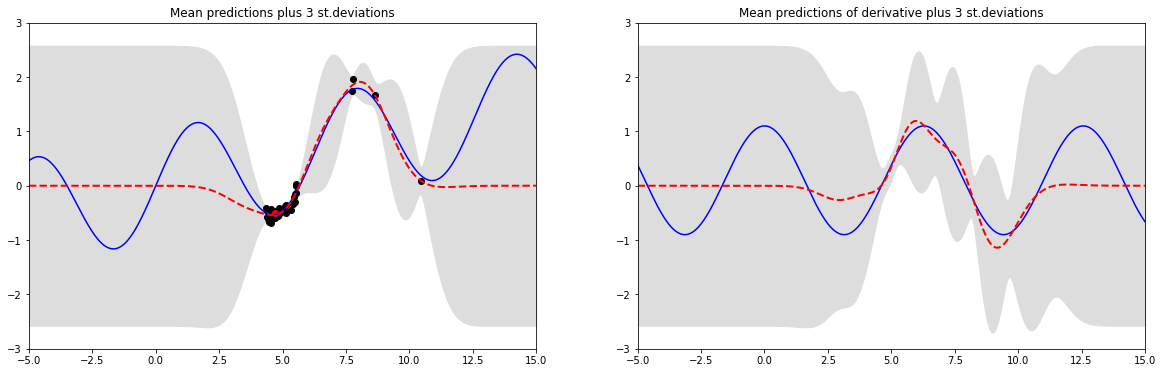

w:  [[4.2247748]]
lr:  7.5


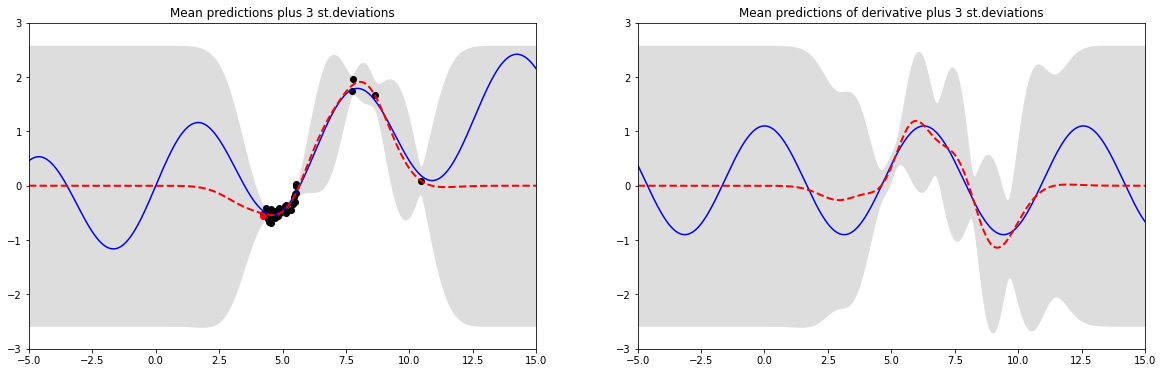

w:  [[4.45599199]]
lr:  1.875


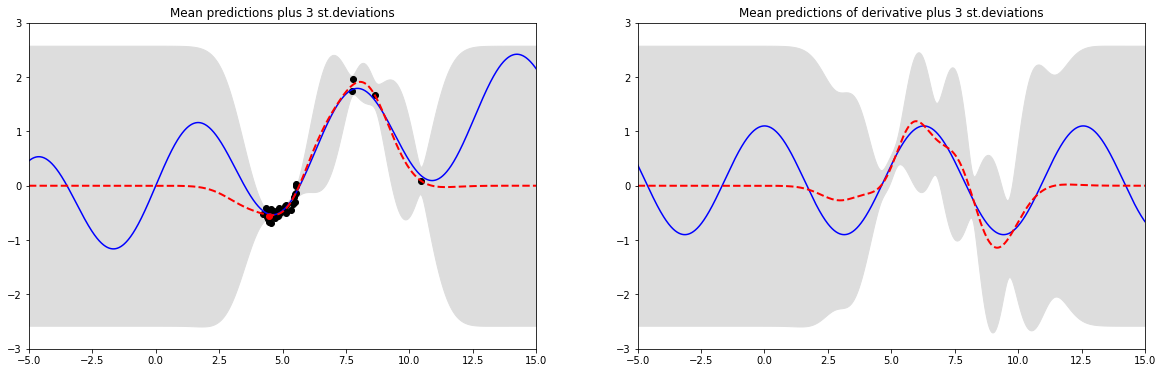

w:  [[4.6880184]]
lr:  3.75


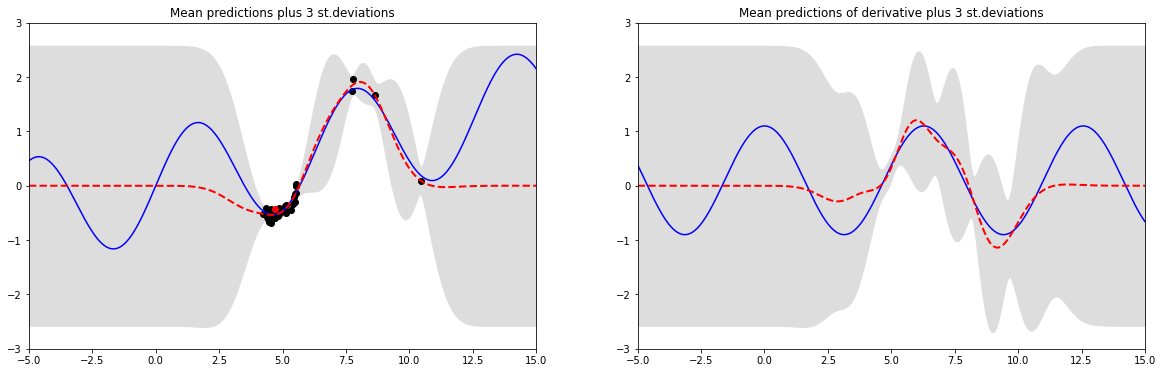

w:  [[4.56486056]]
lr:  1.875


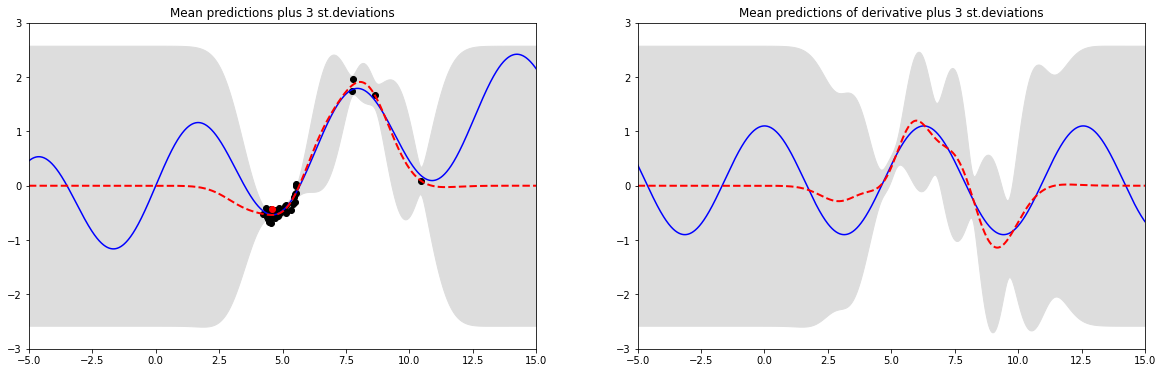

w:  [[4.55980909]]
lr:  15


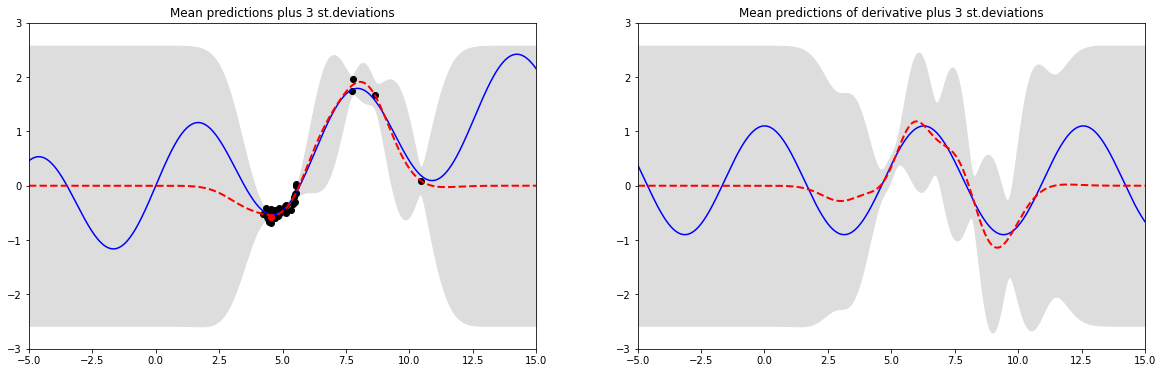

w:  [[4.60768877]]
lr:  15


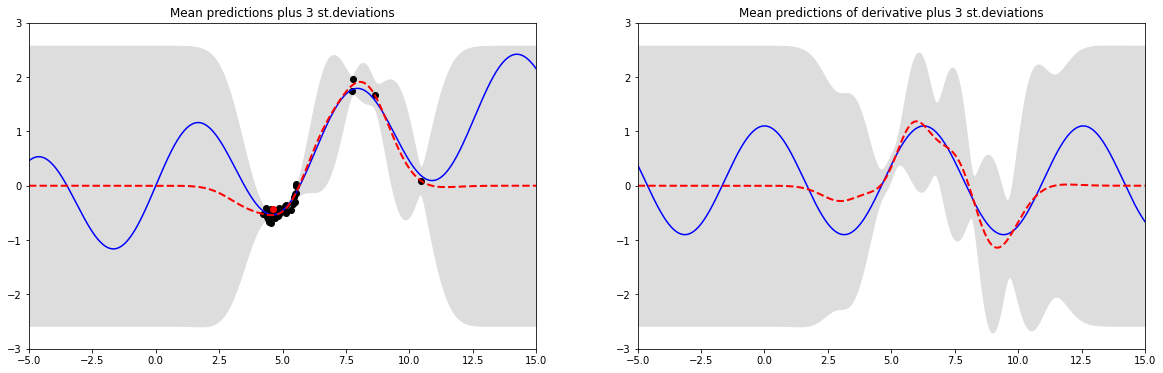

w:  [[4.52471184]]
lr:  3.75


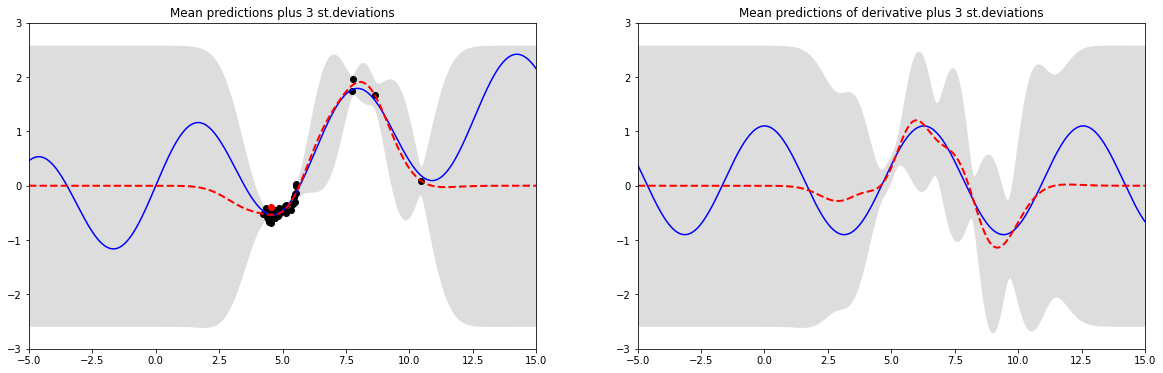

w:  [[4.68150752]]
lr:  7.5


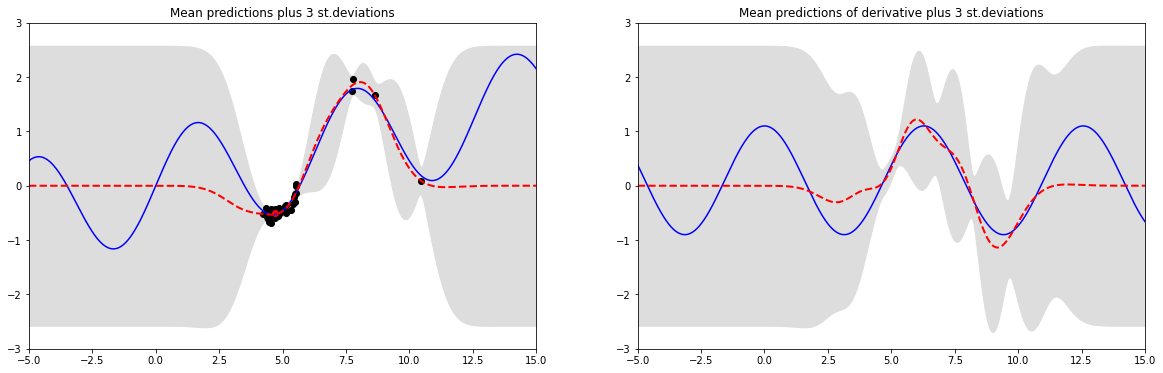

w:  [[4.4388831]]
lr:  3.75


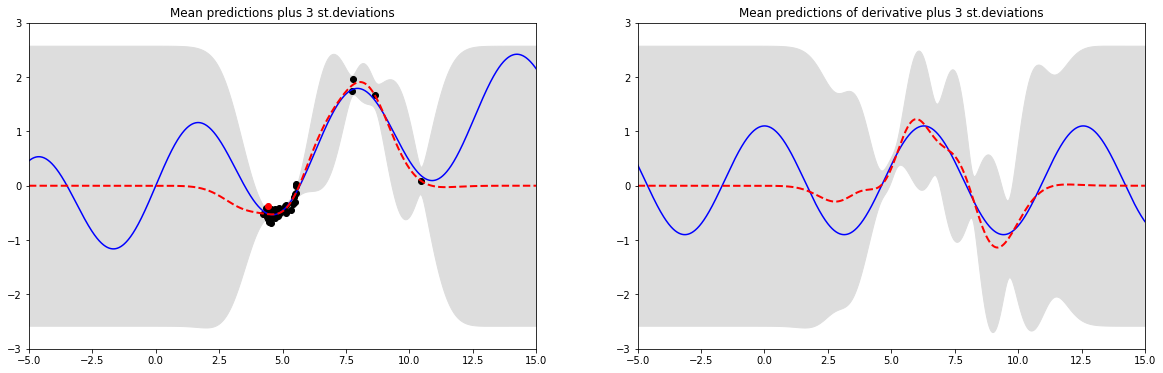

w:  [[5.07359833]]
lr:  15


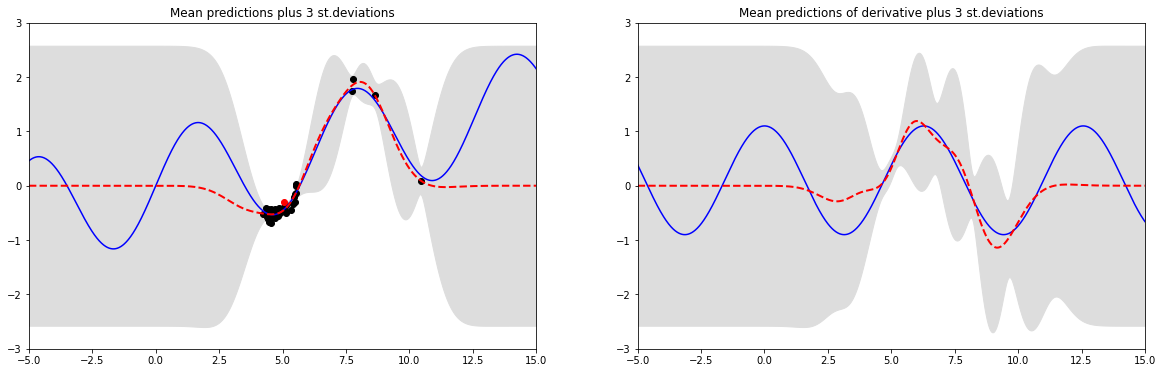

w:  [[4.97847171]]
lr:  0.234375


In [12]:
for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(mesh)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(mesh)
    s_grad = np.sqrt(np.diag(covar_grad))
    mu_grad = np.squeeze(mu_grad)


    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(mesh, mesh, gp.get_hyper())
    K_11 = gp.K11(mesh)
    K_01 = gp.K01(mesh)

    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(np.squeeze(gp.X), np.squeeze(gp.y), 'ko')
    ax1.plot(np.squeeze(w), np.squeeze(f(w)), 'ro')
    
    ax1.plot(mesh.flat, np.sin(mesh.flat) + (0.1*mesh).flat, 'b-')
    ax1.fill_between(mesh.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")

    ax1.plot(mesh, mu, 'r--', lw=2)
    fig.savefig('predictive.png', bbox_inches='tight')
    ax1.set_title('Mean predictions plus 3 st.deviations')
    ax1.axis([-5, 15, -3, 3])


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
    ax2.plot(mesh.flat, np.cos(mesh.flat) + 0.1, 'b-')
    ax2.fill_between(mesh.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")

    ax2.plot(mesh.flat, mu_grad, 'r--', lw=2)
    fig.savefig('predictive_grad.png', bbox_inches='tight')
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')
    ax2.axis([-5, 15, -3, 3])

    filename = 'sin_' + str(i) + '_noise' +'.png'
    pl.savefig('Result_Plots/' + filename)
    pl.show()  

    
    # gradient ascent
    gradient = grad(gp, w)
    desc = -gradient
    
    # automatically choose the learning rate
    lr = lr_init
    while f(w + lr*gradient) > f(w) + alpha*lr*np.dot(desc, gradient):
        # while condition not satisfied, divide the learning rate by two
        lr = 0.5 * lr
    
    w = np.clip(w + lr * desc, -1, 15) # gp.SearchSpace
    print('w: ', w)
    print('lr: ', lr)
    history.append( f(w) )
    history_lr.append(lr)
    gp.add_data(w, f(w))
    gp.fit()

In [13]:
# Creates the .gif from the saved plots for the 2D_Plots dir.
filenames = []
for i in range(1, n_iter):
    filename = 'sin_' + str(i) + '_noise' + '.png'
    filenames.append(filename)

frames=[]
for filename in filenames:
    frames.append(imageio.imread('Result_Plots/' + filename))
exportname = 'sin_GD.gif'

kargs = { 'duration': 0.5 }
imageio.mimsave(exportname, frames, 'GIF', **kargs)

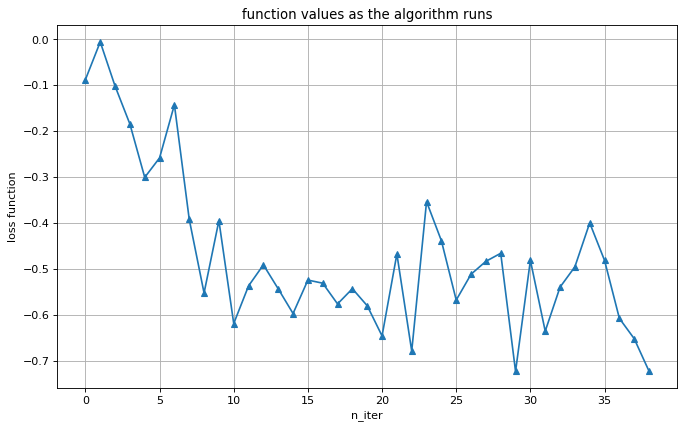

In [14]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

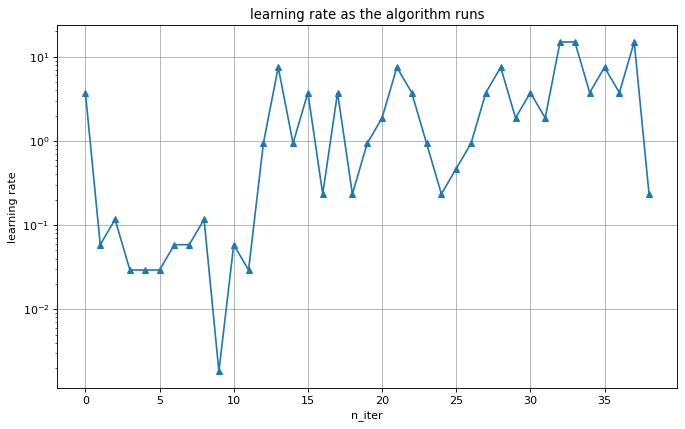

In [15]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(history_lr, "-^")
pl.title("learning rate as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("learning rate")
pl.yscale("log")
pl.grid(True)

In [16]:
history_lr

[3.75,
 0.05859375,
 0.1171875,
 0.029296875,
 0.029296875,
 0.029296875,
 0.05859375,
 0.05859375,
 0.1171875,
 0.0018310546875,
 0.05859375,
 0.029296875,
 0.9375,
 7.5,
 0.9375,
 3.75,
 0.234375,
 3.75,
 0.234375,
 0.9375,
 1.875,
 7.5,
 3.75,
 0.9375,
 0.234375,
 0.46875,
 0.9375,
 3.75,
 7.5,
 1.875,
 3.75,
 1.875,
 15,
 15,
 3.75,
 7.5,
 3.75,
 15,
 0.234375]